### 1. Introduction to Exponential Mechanisms

#### 1.1 Exponential Mechanisms Broaden the Range of Data Types for Queries

What if our database of our brown bear's characteristics and activities contains information that is not numerical?  Exponential mechanisms allow users can query non-numerical data types.  Recall that users of the database may be studying why our beloved brown bears are going bald. What if we had information on our brown bears habits or lifestyle choices other than the number of salmon they eat in a day? What if we had qualitive data on their social habits and wanted to understand if these traits are affecting their fur loss?

#### 1.2 Exponential Mechanisms Only Return Answers That Are Actually Possible Answers

#### 1.3 Exponential Mechanisms Can Incorporate Utility Functions That Tailor Differentially Private Queries 

Users can query based on non-numerical criteria such as "best" according to a "utility" function rather than numerical criteria such as min, max, sum, count, average
    - What if we have additional information the suggests what the optimal eating habits for the brown bear?
    

### 2. The Exponential Mechanism and Our Balding Bears: A Simple Example

#### 2.1 Are Brown Bears Social?

Brown bears have different ranges of social behavior.  What if the degree of social behavior affects their propensity to becoming bald?  Consider a classification of the following for our cadre of brown bears. Assume these qualitative characterizations have been observed for all of our brown bears.

- asocial
- somewhat social
- very social
- extremely social

What if we want to ask the question "What is the most frequent social characteristic of our brown bears?"

Consider the following augmented version of our brown bear database.

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import collections

In [60]:
#Create a dataframe of the balding bears
baldingBears = pd.DataFrame({'Bears': ['Avalanche', 'Bananas', 'Benny', 'Boomer', 'Grizz', 'Kody', 'Monte', 'Nanook', 'Ranger', 'Scott Highlander', 
                                       'Oski'],'School': ['Kutztown', 'U of Maine', 'Morgan State', 'Lake Forest', 'Oakland', 'Cascadia', 'U Montana', 
                                       'Bowdoin', 'Drew', 'UC Riverside','Berkeley'], 'Salmon':[10, 13, 14, 12, 18, 14, 18, 17, 16, 12, 48], 
                                        'Social Behavior':['somewhat social', 'very social', 'somewhat social', 'somewhat social', 'asocial', 
                                                           'very social', 'somewhat social', 'asocial', 'very social', 'somewhat social', 
                                                           'extremely social']})
# add 1 to each index
baldingBears.index = baldingBears.index + 1
baldingBears

,Bears,School,Salmon,Social Behavior
1,Avalanche,Kutztown,10,somewhat social
2,Bananas,U of Maine,13,very social
3,Benny,Morgan State,14,somewhat social
4,Boomer,Lake Forest,12,somewhat social
5,Grizz,Oakland,18,asocial
6,Kody,Cascadia,14,very social
7,Monte,U Montana,18,somewhat social
8,Nanook,Bowdoin,17,asocial
9,Ranger,Drew,16,very social
10,Scott Highlander,UC Riverside,12,somewhat social


In [338]:
def score(col, option):
    # Counts the number of occurances of "option" in a column of a dataframe
    return col.value_counts()[option]

def exponential(column, score, sensitivity, epsilon):
    unique_values = column.unique()
    scores = [score(column, unique_value) for unique_value in unique_values]
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)
    # Choose an element from all unique elements based on the probabilities
    return np.random.choice(unique_values, 1, p=probabilities)[0]


### 2.2 Exponential Mechanism Applied

The Exponential Mechanism generally consists of two main components.  

The **first component** is the "scoring" component.  The scoring component is a function which computes, for each unique instance in a column, how “good” is this instance in the database. Higher scores are better. 

For example, if we are trying to learn how frequent a characterisic is in a database the scoring function will simply compute the frequencies.  If a user queries the database and asks questions such as amoung our bears "What is the most frequent social behavior?", a naive scoring function will simply compute  the existing frequencies and assign a score to each possible characteristic.  Here this score is just the freque3ncy of occurance in the population.

Under these conditions, observe the scores of Social Behavior in our Balding Bears database. Note here they are just the normalized frequencies of occurance.

In [311]:
scoreExample = pd.DataFrame({'Behavior': ['asocial', 'somewhat social', 'very social', 'extremely social'], 
                             'Score': [score(baldingBears['Social Behavior'], 'asocial'),
                              score(baldingBears['Social Behavior'], 'somewhat social'), 
                              score(baldingBears['Social Behavior'], 'very social'),
                              score(baldingBears['Social Behavior'], 'extremely social')]})
# add 1 to each index
scoreExample.index = scoreExample.index + 1
scoreExample

,Behavior,Score
1,asocial,2
2,somewhat social,5
3,very social,3
4,extremely social,1


If the Exponential Mechanism stopped here it would not be differentially private, right?  An attacker could easily learn this fixed distributiom.  Consider the case where we know Oski is an extremely social bear. Eith a fixed "true" response about the frequencies, an attacker's prior belief about Oski's membership could be easily shifted to an actionable posterior as Oksi moves in to the database.

So to protect Oski, the **second component** of the Exponential Mechanism perturbs the results just enough to hide Oski's membership.

These scores are fed to a function in the mechanism that generates a probability function over the set of possible right answers, that behaves somewhat like the Laplace function in terms of protection.  The Exponential Mechanism chooses an answer randomly based on that probability function.

Here is an example.

From the scores, for each possible answer to a query, the mechanism next generates a probability. The set of probabilties for all posible outcomes is a probability mass function.  

In [347]:
unique_values = baldingBears['Social Behavior'].unique()
scores = [score(baldingBears['Social Behavior'], unique_value) for unique_value in unique_values]
epsilon = 1
sensitivity = 1
#Compute probabilities as a function of the scoring functiom
probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
probabilities = probabilities/ np.linalg.norm(probabilities, ord =1)
pmfExample = pd.DataFrame({'Behavior': unique_values, 'Probability': probabilities})
pmfExample.index = scoreExample.index + 1
pmfExample

,Behavior,Probability
2,somewhat social,0.579259
3,very social,0.213097
4,asocial,0.129250
5,extremely social,0.078394


This table shows the probability mass function from which the Exponential Mechanism draws randomly draws its output. We now run the mechanism 10,000 times, with $\epsilon$ = 1 and sensitivity, $\Delta$ = 1. 

*Remember, these parameter settings have a lower degree of privacy ($\epsilon$ high, $\Delta$ low)*

In [345]:
noisyBehaviors = []
col = baldingBears['Social Behavior']
epsilon = 1
sensitivity = 1
num_samples = 10000
for i in range(num_samples):
    noisyBehavior = exponential(col, score, sensitivity,epsilon)
    noisyBehaviors.append(noisyBehavior)

In [318]:
collections.Counter(noisyBehaviors)

Counter({'somewhat social': 5748,
         'extremely social': 827,
         'asocial': 1250,
         'very social': 2175})

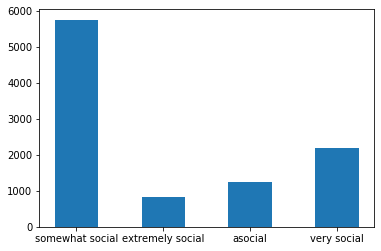

In [319]:
labels, values = zip(*collections.Counter(noisyBehaviors).items())
indexes = np.arange(len(labels))
width = .5
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [320]:
unique_values = baldingBears['Social Behavior'].unique()
scores = [score(baldingBears['Social Behavior'], unique_value) for unique_value in unique_values]
epsilon = 4
sensitivity = 1
#Compute probabilities as a function of the scoring functiom
p = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
p = p/ np.linalg.norm(p, ord =1)
pmfExample = pd.DataFrame({'Behavior': unique_values, 'Probability': p})
pmfExample.index = scoreExample.index + 1
pmfExample

,Behavior,Probability
2,somewhat social,0.979307
3,very social,0.017937
4,asocial,0.002427
5,extremely social,0.000329


In [348]:
col = baldingBears['Social Behavior']
epsilon = 4
sensitivity = 1
for i in range(10000):
    noisyBehavior = exponential(col, score, sensitivity, epsilon)
    noisyBehaviors.append(noisyBehavior)

In [349]:
collections.Counter(noisyBehaviors)

Counter({'somewhat social': 25387,
         'very social': 2459,
         'asocial': 1334,
         'extremely social': 820})

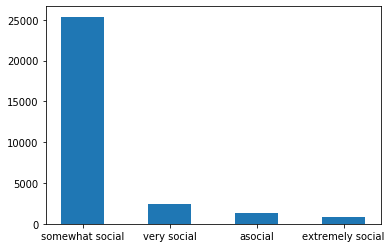

In [350]:
labels, values = zip(*collections.Counter(noisyBehaviors).items())
indexes = np.arange(len(labels))
width = .5
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()